## Recover temporal latent causal factors with simulated data

### Initialize environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import ltcl
import numpy as np
from ltcl.modules.linear_flow import AffineFlow
from ltcl.modules.components.tc import Discriminator, permute_dims
from ltcl.datasets.flow_dataset import SimulationDataset
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torch.utils.data import DataLoader, random_split


In [4]:
def freeze_flow(flow, module_name):
    module = getattr(flow, module_name)
    for param in module.parameters():
        param.requires_grad = False
        
def unfreeze_flow(flow, module_name):
    module = getattr(flow, module_name)
    for param in module.parameters():
        param.requires_grad = True

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
batch_size = 64
max_epochs = 1

In [6]:
num_validation_samples = 500
train_data = SimulationDataset(split='train')
val_data = SimulationDataset(split='val')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=128, shuffle=False, pin_memory=True)

In [7]:
flow = AffineFlow(input_size = 32, 
                  lags = 2,
                  batch_norm = True,
                  diagonal=False)
flow = flow.to(device)
d = Discriminator(80 * 4).to(device)

In [8]:
# flow.load_state_dict(torch.load("../flow.pth"))

In [9]:
# Manual tuning
freeze_flow(flow, "dconv")
freeze_flow(flow, "unmix")
unfreeze_flow(flow, "spline")

In [10]:
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, flow.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)

In [11]:
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 32
#     y_1 = torch.exp(torch.normal(0, 1, size=(batch_size, latent_size//2)))
#     y_1 = torch.normal(0, 1, size=(batch_size, latent_size//2))
    y_1 =  torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size//2))
                # y_2 = torch.rand(batch_size, latent_size//2) - 0.5
    y_2 = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size//2))
#     y_2 = torch.normal(0, 1, size=(batch_size, latent_size//2))
#     y_2 = torch.distributions.uniform.Uniform(-0.5, 0.5).sample((batch_size, latent_size//2))
    dataset = torch.cat((y_1, y_2), dim=1).to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = flow.spline(dataset)
    logp = flow.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

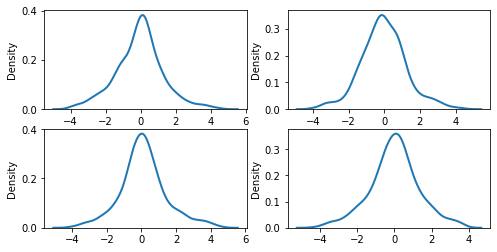

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8,4))
for idx in range(4):
    row = idx // 2
    col = idx % 2
#     sns.distplot(y_t[:,idx], hist=False, kde=True,
#                  bins=None,
#                  hist_kws={'edgecolor':'black'},
#                  kde_kws={'linewidth': 2},
#                  ax = axs[row,col], label="prior");
#     axs[row,col].legend()
    sns.distplot(flow.sample_prior(1280).detach().cpu().numpy()[:,idx], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 ax = axs[row,col], label="prior");

In [12]:
# Manual tuning
unfreeze_flow(flow, "dconv")
unfreeze_flow(flow, "unmix")
unfreeze_flow(flow, "spline")
flow_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, flow.parameters()), 
                                  lr=1e-4,
                                  weight_decay=0.0)
d_optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, d.parameters()), 
                               lr=1e-4)

In [13]:
# Manual tuning
# unfreeze_flow(flow, "dconv")
# unfreeze_flow(flow, "unmix")
# freeze_flow(flow, "spline")

In [14]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [15]:
BB2 = np.load("/home/cmu_wyao/projects/data/flow/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/flow/W1.npy")

In [16]:
BB1

array([[-0.08519712,  0.01090741, -0.19091386, ...,  0.01555011,
         0.17878783, -0.05717504],
       [ 0.10259572,  0.08734378,  0.1842005 , ...,  0.09634686,
        -0.10463971, -0.09237361],
       [-0.09900758,  0.02318466, -0.13005498, ..., -0.24857515,
         0.12246469,  0.06565994],
       ...,
       [-0.23303849, -0.05939579, -0.05113336, ...,  0.11089718,
         0.17073363,  0.19217256],
       [-0.13300121, -0.10344577,  0.17978886, ...,  0.06358516,
        -0.05150634, -0.22001323],
       [ 0.1607374 ,  0.00207543,  0.15689355, ..., -0.03184855,
         0.22872815,  0.21846655]], dtype=float32)

In [17]:
BB2

array([[-0.07412443, -0.11986747, -0.0714162 , ..., -0.03136978,
        -0.10618444,  0.12415701],
       [ 0.01982673, -0.08536404,  0.05909775, ..., -0.10312749,
         0.01880452, -0.00406672],
       [ 0.02588797, -0.01190884,  0.10920888, ..., -0.1176348 ,
         0.10069786,  0.10857208],
       ...,
       [ 0.09497286, -0.0764109 , -0.03219688, ...,  0.09164275,
         0.04185665, -0.04132424],
       [ 0.02561058,  0.11668284,  0.11532295, ...,  0.03294674,
        -0.01287456,  0.07398903],
       [-0.07364424,  0.10446088,  0.04006942, ..., -0.00437921,
        -0.11616066, -0.09978762]], dtype=float32)

### Training

In [20]:
import tqdm

In [25]:
batch_size = 64
ones = torch.ones(batch_size, dtype=torch.long, device=device)
zeros = torch.zeros(batch_size, dtype=torch.long, device=device)
eye = torch.eye(320, device=device)
gamma = 25
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    flow_running_loss = 0
    d_running_loss = 0
    for batch_sample1, batch_sample2 in train_loader:
        batch_x = batch_sample1["x"]
        batch_y = batch_sample1["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        flow_optimizer.zero_grad()
        log_prob, e = flow.log_prob(batch_x, batch_y)
        # Spatialtemporal decorrelation
#         posteriors = flow(batch_x, batch_y)[0].reshape(batch_size, -1)
#         fro_norm = torch.norm(torch.mm(posteriors.T, posteriors) - eye, "fro")
#         Total correlation
        e = e.reshape(batch_size, -1)
        D_e = d(e)
        tc_loss = (D_e[:, :1] - D_e[:, 1:]).mean()
        flow_loss = -log_prob + gamma * tc_loss #+ fro_norm #+ gamma * tc_loss
        flow_loss.backward(retain_graph=True)
        flow_optimizer.step()
        
        # Discrimator traing
        d_optimizer.zero_grad()
        e = e.detach()
        D_e = d(e)
        batch_xx = batch_sample2["x"]
        batch_yy = batch_sample2["y"]  
        # Transfer to GPU
        batch_xx, batch_yy = batch_xx.to(device), batch_yy.to(device)
        _, e_prime = flow.log_prob(batch_xx, batch_yy)
        e_prime = e_prime.reshape(batch_size, -1)
        e_perm = permute_dims(e_prime).detach()
        D_e_pperm = d(e_perm)
        if random.random() < 0.1:
            D_tc_loss = 0.5*(F.cross_entropy(D_e, ones) + F.cross_entropy(D_e_pperm, zeros))
        else:
            D_tc_loss = 0.5*(F.cross_entropy(D_e, zeros) + F.cross_entropy(D_e_pperm, ones))
        D_tc_loss.backward()
        d_optimizer.step()
        flow_running_loss += flow_loss.item()
        d_running_loss += D_tc_loss.item()

    print(f"Flow loss: {flow_running_loss/len(train_loader)} D loss: {d_running_loss/len(train_loader)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample, _ in val_loader:
            # Transfer to GPU
            batch_x = batch_sample["x"]
            batch_y = batch_sample["y"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            log_prob, _ = flow.log_prob(batch_x, batch_y)
            flow_loss = -log_prob
            running_loss += flow_loss.item()
        print(f"Validation loss: {running_loss/len(val_loader)}")
    W2 = flow.dconv.step_func.wt_func.get_weight_matrix()[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.get_weight_matrix()[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [42]:
    W2 = flow.dconv.step_func.wt_func.get_weight_matrix()[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.get_weight_matrix()[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.504038, 0.35422644)


In [37]:
samples = flow.sample(batch_y, batch_y.shape[0], 80)

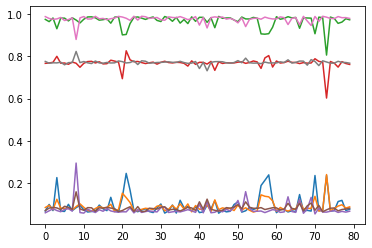

In [38]:
plt.plot(samples[3].detach().cpu().numpy())
plt.plot(batch_x[3].detach().cpu().numpy())

In [33]:
print(f"Training loss: {running_loss/len(train_loader)}")

NameError: name 'running_loss' is not defined

In [23]:
batch_x.shape

torch.Size([64, 5, 4])

In [24]:
batch_y.shape

torch.Size([64, 2, 4])

In [18]:
# Loop over epochs
batch_size=64
for epoch in range(3):
    # Training
    running_loss = 0
    for batch_sample1,_ in train_loader:
        batch_x = batch_sample1["x"]
        batch_y = batch_sample1["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        flow_optimizer.zero_grad()
        log_prob, e = flow.log_prob(batch_x, batch_y)
        # Model computations
        flow_loss = -log_prob
        flow_optimizer.zero_grad()
        flow_loss.backward(retain_graph=True)
        flow_optimizer.step()
        running_loss += flow_loss.item()

    print(f"Training loss: {running_loss/len(train_loader)}")
    W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

Training loss: -4147.706516876221
Amari index: (0.31756735, 0.2770651)
Training loss: -4876.265712280274
Amari index: (0.23158853, 0.32476386)
Training loss: -5008.772245483398
Amari index: (0.22292303, 0.29313463)


In [27]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0
    for batch_sample1 in train_loader:
        batch_x = batch_sample1["xt_"]
        batch_y = batch_sample1["xt"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        log_prob, e = flow.log_prob(batch_x, batch_y)
        flow_loss = -log_prob
        flow_optimizer.zero_grad()
        flow_loss.backward(retain_graph=True)
        flow_optimizer.step()
        running_loss += flow_loss.item()

    print(f"Training loss: {running_loss/len(train_loader)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample in val_loader:
            # Transfer to GPU
            batch_x = batch_sample["xt_"]
            batch_y = batch_sample["xt"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            log_prob, _ = flow.log_prob(batch_x, batch_y)
            flow_loss = -log_prob
            running_loss += flow_loss.item()
        print(f"Validation loss: {running_loss/len(val_loader)}")
    W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

TypeError: list indices must be integers or slices, not str

In [28]:
torch.save(flow.state_dict(), "../flow.pth")

In [60]:
import torch.nn as nn

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

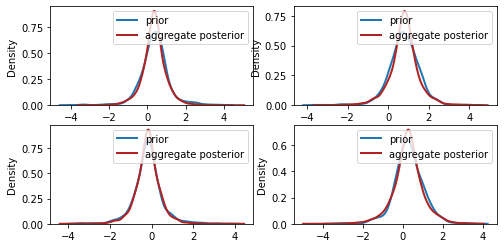

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8,4))
for idx in range(4):
    row = idx // 2
    col = idx % 2
    sns.distplot(flow.sample_prior(1000).detach().cpu().numpy()[:,idx], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 ax = axs[row,col], label="prior");
    sns.distplot(flow(batch_x, batch_y)[0][:,:,idx].reshape(-1).detach().cpu().numpy(), hist=False, kde=True,
                 bins=None, color='firebrick',
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='aggregate posterior',
                 ax = axs[row, col]);
    axs[row,col].legend()

In [20]:
# # Loop over epochs
# for epoch in range(max_epochs):
#     # Training
#     running_loss = 0
#     for batch_sample1, _ in training_generator:
#         batch_x = batch_sample1["x"]
#         batch_y = batch_sample1["y"]
#         # Transfer to GPU
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         # Model computations
#         log_prob, e = flow.log_prob(batch_x, batch_y)
#         # Spatialtemporal decorrelation
# #         posteriors = flow(batch_x, batch_y)[0].reshape(batch_size, -1)
# #         fro_norm = torch.norm(torch.mm(posteriors.T, posteriors) - eye, "fro")
# #         Total correlation
# #         e = e.reshape(batch_size, -1)
# #         D_e = d(e)
# #         tc_loss = (D_e[:, :1] - D_e[:, 1:]).mean()
#         flow_loss = -log_prob #+ gamma * tc_loss #+ fro_norm #+ gamma * tc_loss
#         flow_optimizer.zero_grad()
#         flow_loss.backward(retain_graph=True)
#         flow_optimizer.step()
        
#         # Discrimator traing
# #         e = e.detach()
# #         D_e = d(e)
# #         batch_xx = batch_sample2["x"]
# #         batch_yy = batch_sample2["y"]  
# #         # Transfer to GPU
# #         batch_xx, batch_yy = batch_xx.to(device), batch_yy.to(device)
# #         _, e_prime = flow.log_prob(batch_xx, batch_yy)
# #         e_prime = e_prime.reshape(batch_size, -1)
# #         e_perm = permute_dims(e_prime).detach()
# #         D_e_pperm = d(e_perm)
# #         D_tc_loss = 0.5*(F.cross_entropy(D_e, zeros) + F.cross_entropy(D_e_pperm, ones))
# #         d_optimizer.zero_grad()
# #         D_tc_loss.backward()
# #         d_optimizer.step()
#         running_loss += flow_loss.item()

#     print(f"Training loss: {running_loss/len(training_generator)}")
#     # Validation
#     running_loss = 0
#     with torch.set_grad_enabled(False):
#         for batch_sample, _ in validation_generator:
#             # Transfer to GPU
#             batch_x = batch_sample["x"]
#             batch_y = batch_sample["y"]
#             # Transfer to GPU
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#             log_prob, _ = flow.log_prob(batch_x, batch_y)
#             flow_loss = -log_prob
#             running_loss += flow_loss.item()
#         print(f"Validation loss: {running_loss/len(validation_generator)}")
#     W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
#     W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
#     B2 = - W2
#     B1 = - W1
#     am2 = amari_distance(np.linalg.inv(B2) @ BB2)
#     am1 = amari_distance(np.linalg.inv(B1) @ BB1)
#     print(f"Amari index: {am2[0], am1[0]}")

In [21]:
# def align_matrices(B1, B2, BB1, BB2):
#     b = np.concatenate((B1,B2), axis=0)
#     bb = np.concatenate((BB1,BB2), axis=0)
#     C = np.zeros((4,4))
#     for i in range(4):
#         C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])
#     row_ind, col_ind = linear_sum_assignment(C)
#     bb = bb[:, col_ind]
#     for col in range(4):
#         if np.corrcoef(np.concatenate((b[:,col:col+1], bb),axis=1), rowvar=False)[0,1:][col] < 0:
#             bb[:, col] = -bb[:, col]
#     b = b / np.linalg.norm(b, axis=0)
#     bb = bb / np.linalg.norm(bb, axis=0)
#     am1 = amari_distance(np.linalg.inv(bb[4:]) @ bb[4:])

In [30]:
B1.shape

(32, 32)

In [20]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
bb = bb[:, col_ind]
for col in range(latent_size):
    if np.corrcoef(np.concatenate((b[:,col:col+1], bb),axis=1), rowvar=False)[0,1:][col] < 0:
        bb[:, col] = -bb[:, col]
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

In [21]:
C[row_ind, col_ind]

array([-0.9814288 , -0.9604318 , -0.97392915, -0.967248  , -0.947044  ,
       -0.97871758, -0.9744088 , -0.95030912, -0.97139694, -0.97095432,
       -0.95942938, -0.97688656, -0.97637625, -0.94334206, -0.97930935,
       -0.97868766, -0.98345253, -0.95022418, -0.96678235, -0.97848842,
       -0.98781841, -0.97732848, -0.98369793, -0.9676401 , -0.97753016,
       -0.98464499, -0.98517638, -0.97978288, -0.97793752, -0.979008  ,
       -0.98237822, -0.97774927])

Text(0, 0.5, 'Ground truth weight')

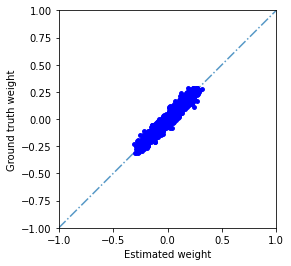

In [22]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=15, cmap=plt.cm.coolwarm, zorder=10, alpha=1, color='b')
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

In [24]:
from sklearn.metrics import r2_score

In [25]:
r2_score(pred,true)

0.9451037277219173